# Query HDFS Data
In this tutorial you will query the HDFS data you ingested using the MonIT flow. 
## Prerequisites 
  - A swan environment:
      - go to https://swan.cern.ch, login and create a new session with the following configuration:
          - Software stack `96 Python 3`
          - Platform `CentOS 7 (gcc8)`
          - Number of cores 4
          - Memory 8 GB
          - Spark cluster `Analytix`
  - This notebook.
      - In swan, create a new project (using the + button). Enter to the project folder. 
      - Download this notebook and import it to the new project using the upload file button.

# Before start running the notebook      

Swan will take care of the creation of the spark session/spark context variables. In order to do so you need to start the spark session using the star icon.
![]( 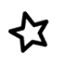)
For this notebook you can start the session using the default configuration. 
Before clicking connect take some time to explore this interface, some useful variables you could set here are:
  - spark.executor.memory
  - spark.driver.memory
  - spark.executor.instances
  - spark.executor.cores
  - spark.sql.shuffle.partitions

Once you are connected to the spark session two variables are created for you:
    - `spark`: The spark session
    - `sc`: The spark context
Run the next cell to see more information about them:

In [2]:
display(spark)
display(sc)

<SparkContext master=yarn appName=pyspark_shell_swan>

Also, as you are now connected to a hadoop cluster, you can use the Hadoop (elephant) icon to browse the data in HDFS. Use it to see the available dates in `/project/monitoring/archive/condor/raw/metric/`




# Read a json dataset using spark
If you know the schema or the fields you want to query, you should specify it. Otherwise the spark.read.json will try to infer the schema reading the whole dataset (by default, you can use an option to make it use only a sample). 
Most of the time you only need a subset of the available fields, you only need to specify that subset in the schema. 

*Run the following cell to create a spark dataframe with the desired fields.*

To see the efects of specifying the schema, you could run the same cell without specifying the schema. **WARNING**: Spark operations are lazy, they execute only when you call an action, but the infer schema step will start inmediatelly and for this data can take around 8 minutes to finish with 64 executors and two cores per executor. 

In [3]:
from pyspark.sql.types import StructField, StructType, StringType, LongType
_schema = StructType([
    StructField('metadata', StructType([StructField("_id",StringType(), nullable=False), 
                                        StructField("timestamp",LongType(), nullable=False)])),
    StructField('data', StructType([
        StructField("GlobalJobId", StringType(), nullable=False),
        StructField("RecordTime", LongType(), nullable=False),
        StructField("Status", StringType(), nullable=True),
        StructField("CMSPrimaryPrimaryDataset", StringType(), nullable=True),
        
    ])),
])

condor_df = spark.read.json("/project/monitoring/archive/condor/raw/metric/2019/10/31", schema=_schema)

Now we can process the data, for example we can query for the most popular datasets (the dataset that appears on more jobs as primary dataset), considering only the completed jobs.

In [4]:
# First, we select the fields we want to work with. (Exploding the nested structures will make easier to work with the data)
# We filter the records to only take into account the ones we want. 
# And we drop duplicates, as we want to count every job only once. 
condor_df = condor_df.select("data.*").where("Status = 'Completed' AND CMSPrimaryPrimaryDataset IS NOT NULL").drop_duplicates(["GlobalJobId"])

In [5]:
# Now we group and count by Dataset, and filter out the datasets that appear on only one job. 
grouped_data = condor_df.groupby("CMSPrimaryPrimaryDataset").count().where("count>1").orderBy("count", ascending=False)

Note that, so far, we haven't perform any opperation on our data, because all the methods we have used so far are transformations. 

Now we will use an action to create the spark job. 
As we know that we will have small number of rows and only two columns we can use the toPandas method to get the data into the driver as a pandas dataframe. Be aware of the amount of data you get into the driver as it must fit into memory. If your results are two big to collect them in one machine you can write them back to HDFS.
```
grouped_data.write.csv("outputFolder",header="True")
```

In [6]:
grouped_data.toPandas()

,CMSPrimaryPrimaryDataset,count
0,Unknown,564214
1,SingleMuon,63395
2,EGamma,39830
3,DoubleMuon,31217
4,Charmonium,30639
5,SingleElectron,26995
6,GenericTTbar,26354
7,DoubleMuonLowMass,16396
8,JetHT,10525
9,DoubleEG,9788


Now that you have seen the result on a small time period, try changing the file path to have several days. You can do it either changing the string for a list of paths, or using glob expressions. 
e.g.

```python 
# all October
condor_df = spark.read.json("/project/monitoring/archive/condor/raw/metric/2019/10/*", schema=_schema)

```

```python 
# May to October 2019
condor_df = spark.read.json("/project/monitoring/archive/condor/raw/metric/2019/{05,06,07,08,09,10}/*", schema=_schema)
```
```python 
# May to October 2019 (as list)
condor_df = spark.read.json(["/project/monitoring/archive/condor/raw/metric/2019/05/*",
                             "/project/monitoring/archive/condor/raw/metric/2019/06/*",
                             "/project/monitoring/archive/condor/raw/metric/2019/07/*",
                             "/project/monitoring/archive/condor/raw/metric/2019/08/*",
                             "/project/monitoring/archive/condor/raw/metric/2019/09/*",
                             "/project/monitoring/archive/condor/raw/metric/2019/10/*"], schema=_schema)
```
(As this parameters include glob expressions, the json will trigger a job to find the leaf nodes, i.e. the actual filenames). 

In [7]:
_schema = StructType([
    StructField('metadata', StructType([StructField("_id",StringType(), nullable=False), 
                                        StructField("timestamp",LongType(), nullable=False)])),
    StructField('data', StructType([
        StructField("GlobalJobId", StringType(), nullable=False),
        StructField("RecordTime", LongType(), nullable=False),
        StructField("Status", StringType(), nullable=True),
        StructField("CMSPrimaryPrimaryDataset", StringType(), nullable=True),
        
    ])),
])

condor_df = spark.read.json("/project/monitoring/archive/condor/raw/metric/2019/{05,06,07,08,09,10}/*", schema=_schema)
# First, we select the fields we want to work with. (Exploding the nested structures will make easier to work with the data)
# We filter the records to only take into account the ones we want. 
# And we drop duplicates, as we want to count every job only once. 
condor_df = condor_df.select("data.*").where("Status = 'Completed' AND CMSPrimaryPrimaryDataset IS NOT NULL").drop_duplicates(["GlobalJobId"])
# Now we group and count by Dataset, and filter out the datasets that appear on only one job. 
grouped_data = condor_df.groupby("CMSPrimaryPrimaryDataset").count()\
                        .where("count>1")\
                        .orderBy("count", ascending=False)
# We only want the top datasets, so we can limit the result before transfering
grouped_data.limit(500).toPandas()

,CMSPrimaryPrimaryDataset,count
0,Unknown,88202619
1,SingleMuon,8463715
2,DoubleMuon,4398147
3,SingleElectron,4202633
4,GenericTTbar,4195163
5,EGamma,4072199
6,Charmonium,3755827
7,DoubleEG,2792724
8,JetHT,1774531
9,MuonEG,1292059
